In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r^2": r_score,}

In [22]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,15 mins 01 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 23 days
H2O_cluster_name:,H2O_from_python_38066_vv52iw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.429 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment', 'RPCS']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           molecule_type="amine",
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    elif "angle" in feature_name or "distance" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

# train = h2o.H2OFrame(train_df)
# test = h2o.H2OFrame(test_df)

True
128
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
mol_weight outliers indexes: [28]
f_atom_fraction outliers indexes: [69]
distance_between_atoms_in_cycle_and_f_group outliers indexes: [112 113]
sasa outliers indexes: [72]
logP outliers indexes: [27]
Remains rows:118, amount of features: 40
feature without unique values: nN
100 18


In [5]:
test_df.columns

Index(['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5',
       'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'FPSA3', 'nF', 'chirality',
       'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'mol_num_cycles',
       'f_freedom', 'nFRing', 'identificator', 'nO', 'nARing', 'nC', 'nFHRing',
       'f_to_fg', 'pKa'],
      dtype='object')

In [24]:
x = train.columns
y = "pKa"
x.remove(y)

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |█
09:20:29.963: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
09:20:29.964: AutoML: XGBoost is not available; skipping it.
09:20:30.18: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 100.0.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse       mse       mae      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_5_AutoML_3_20240213_92029  0.67113   0.450415  0.510847  0.0757664                  0.450415
StackedEnsemble_BestOfFamily_3_AutoML_3_20240213_92029  0.672683  0.452502  0.509314  0.0762228                  0.452502
DeepLearning_grid_1_AutoML_3_20240213_92029_model_122   0.677062  0.458413  0.499817  0.0766312                  0.458413
DeepLearning_grid_1_AutoML_3_20240213_92029_model_333   0.680726  0.463388  0.489195  0.0765858    

TRAIN

In [25]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.021, 'mae': 0.108, 'r^2': 0.992}

OOS

In [26]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.464, 'mae': 0.55, 'r^2': 0.753}

BEST_MODEL(for cross-val metrics)

In [27]:
best_model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/5
# GBM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),1/1
# DRF base models (used / total),0/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,fold_id


PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_26636\1575081460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

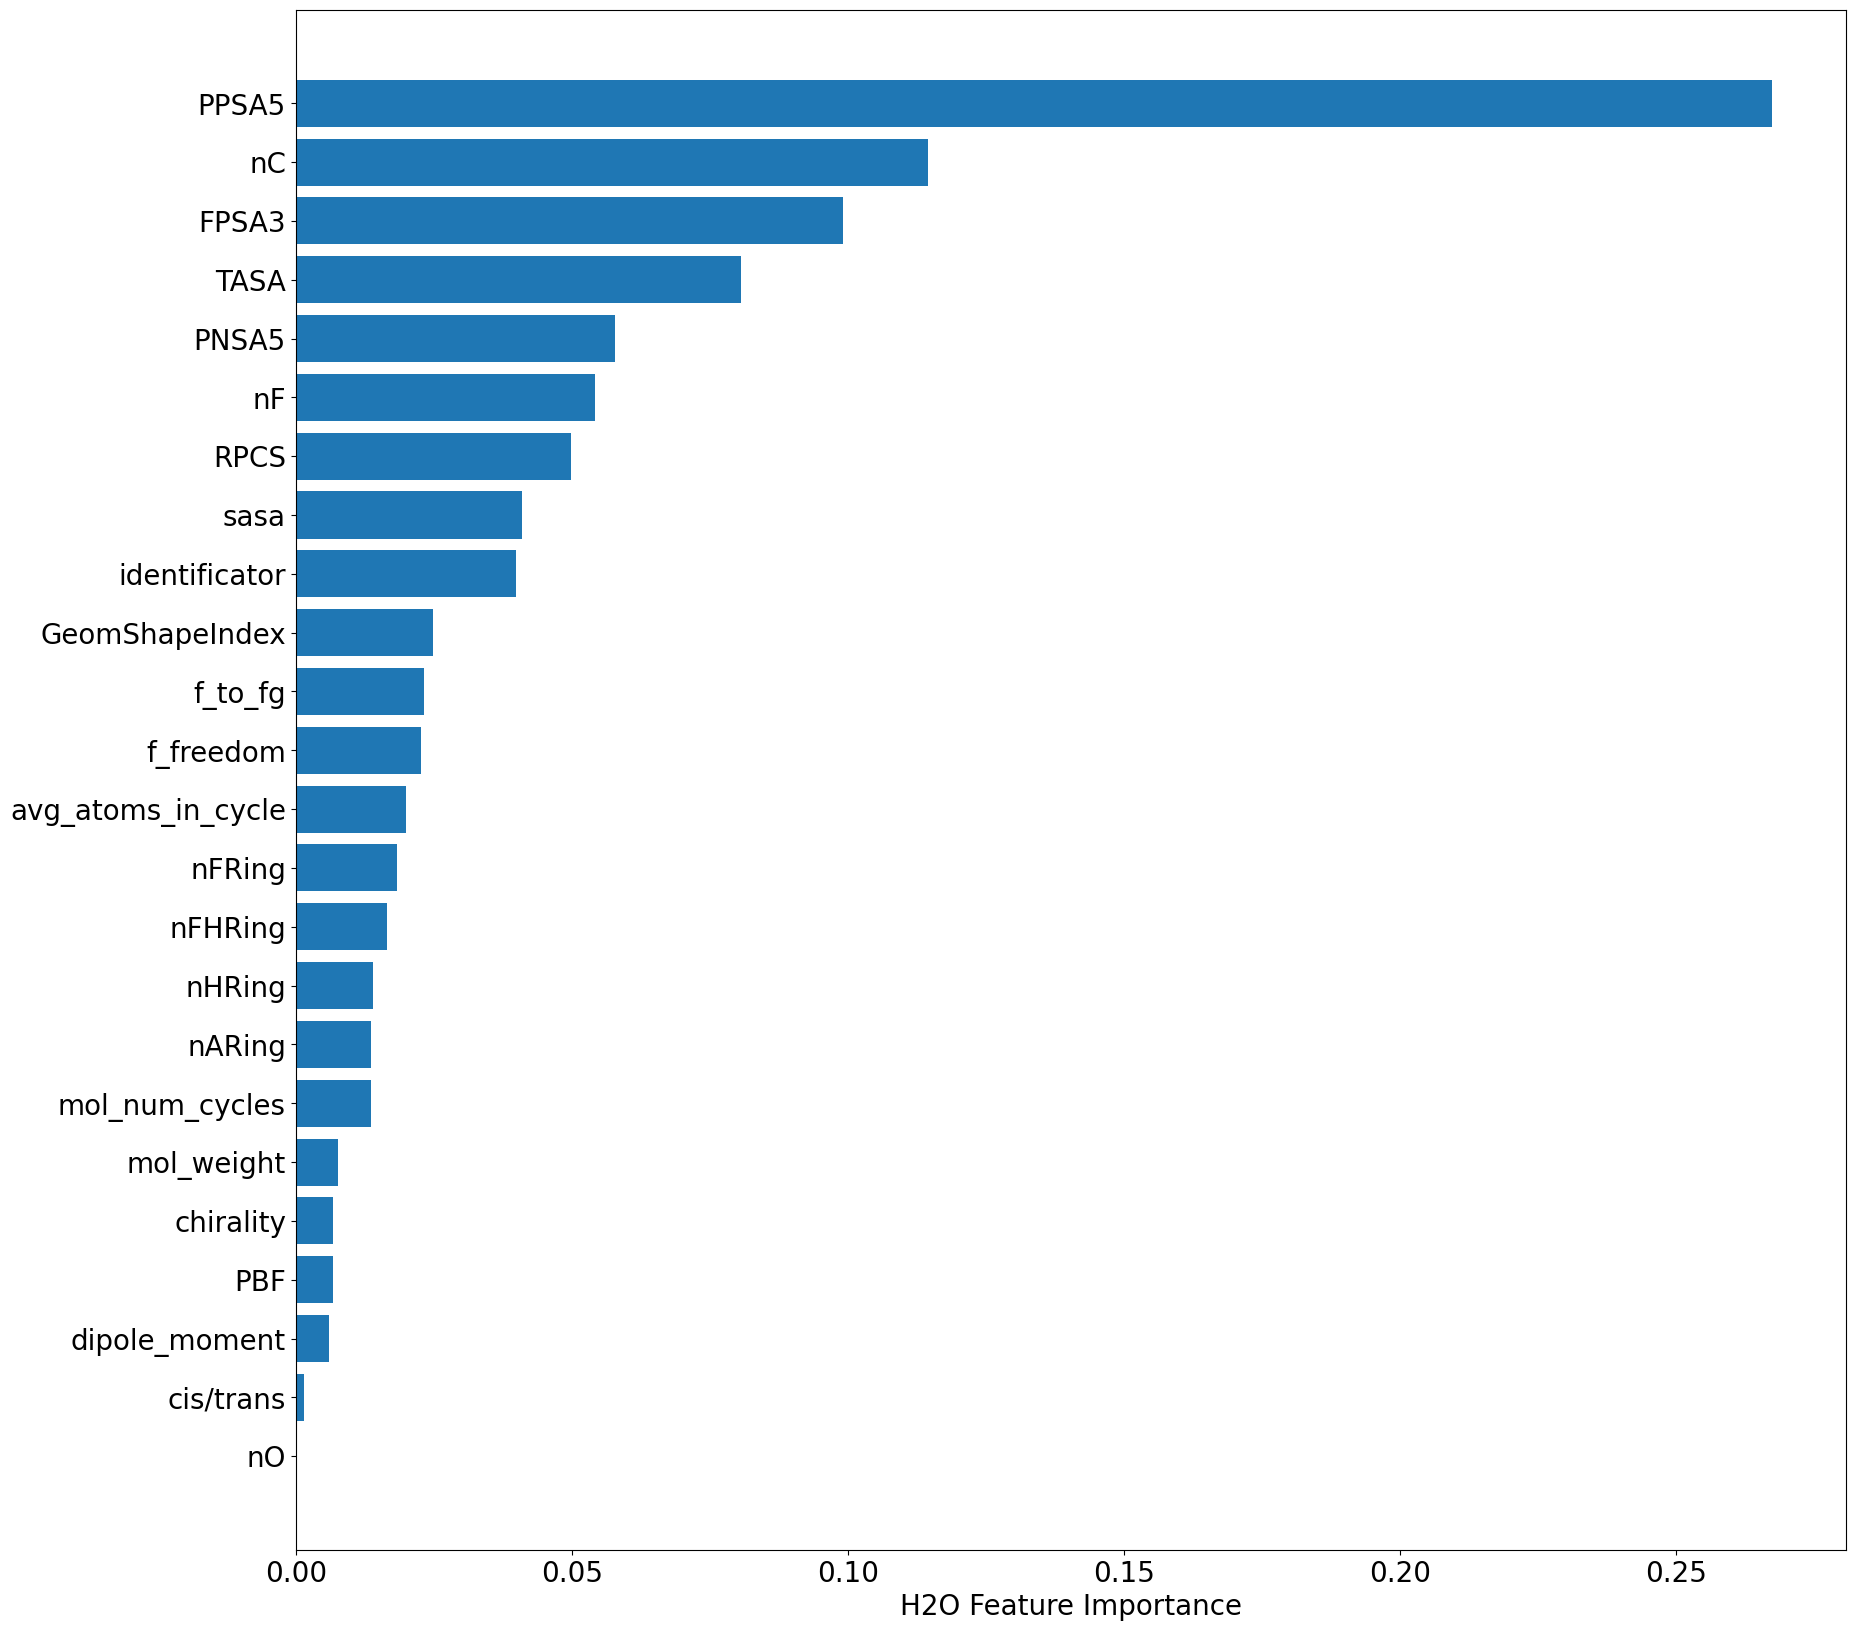

In [28]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

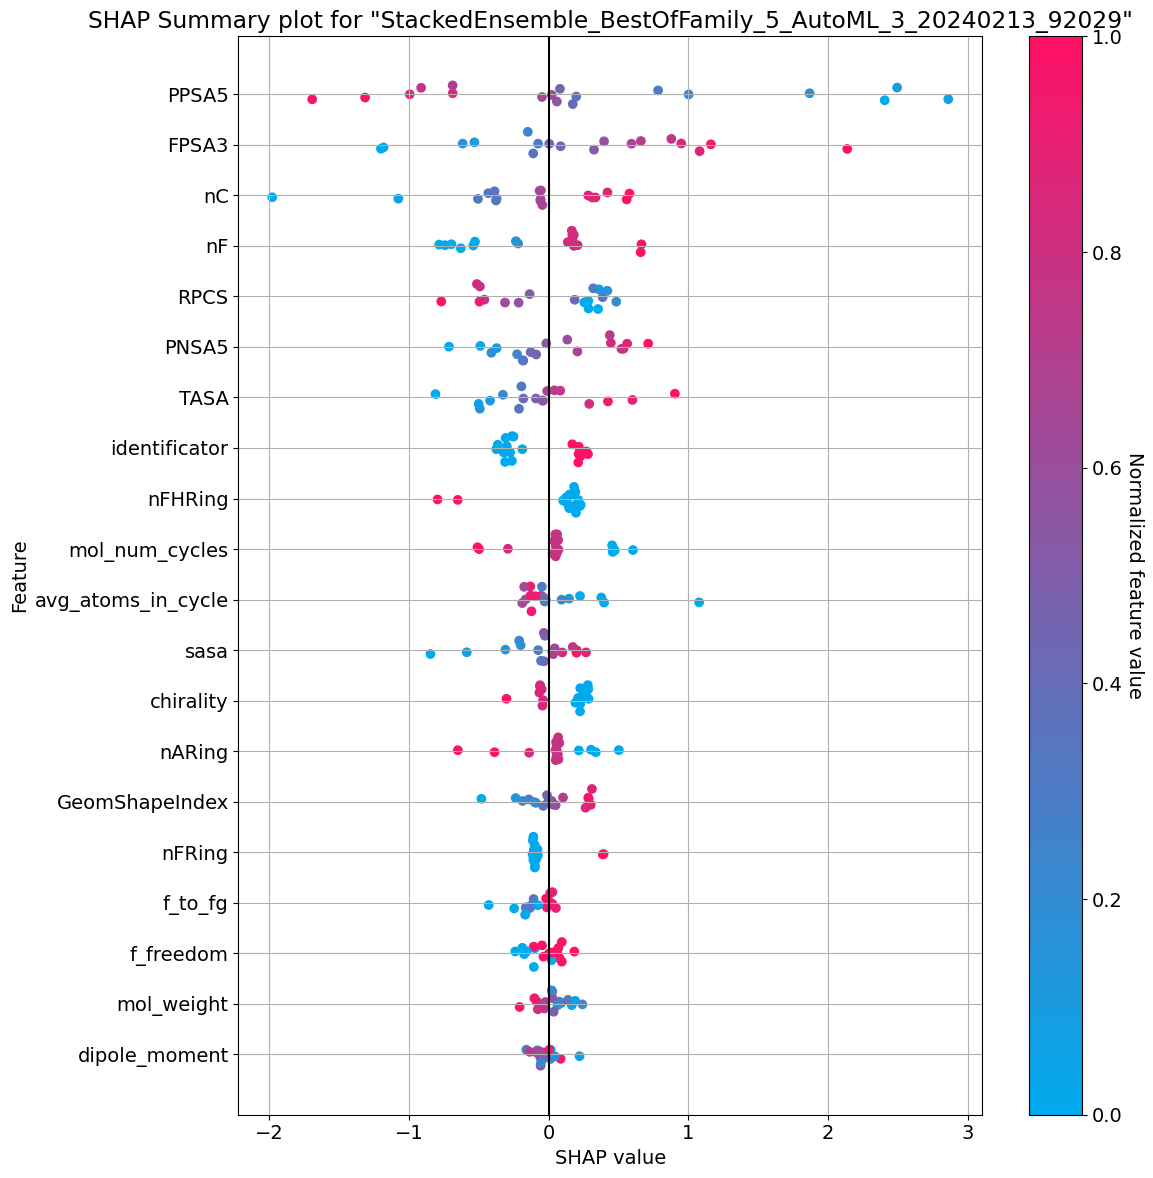

In [29]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=1000)

VAR IMPORTANCE

In [30]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

importance = best_model.varimp(test)

if importance is not None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
    ax.set_xlabel('Percent')


In [31]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\08.02.24_feature_2.2\pKa'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'amine_molecules(without_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\pKa\\amine_molecules(without_angle_feature)_without_outliers\\StackedEnsemble_BestOfFamily_5_AutoML_3_20240213_92029'

--------------

----------------

------------------

ACID MOLECULES

In [32]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment', 'RPCS']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           molecule_type="acid",
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    elif "angle" in feature_name or "distance" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
55
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
PBF outliers indexes: [40]
PPSA5 outliers indexes: [39, 40]
FPSA3 outliers indexes: [40]
GeomShapeIndex outliers indexes: [50]
logP outliers indexes: [48]
Remains rows:50, amount of features: 40
feature without unique values: nN
feature without unique values: identificator
42 8
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |███████████████████████████████████████████████████████████

In [33]:
x = train.columns
y = "pKa"
x.remove(y)

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |█
10:23:21.990: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
10:23:21.991: AutoML: XGBoost is not available; skipping it.
10:23:22.90: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 42.0.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                              rmse        mse       mae      rmsle    mean_residual_deviance
DeepLearning_grid_2_AutoML_4_20240213_102321_model_43             0.230636  0.0531931  0.165587  0.0474642                 0.0531931
StackedEnsemble_BestOfFamily_6_AutoML_4_20240213_102321           0.235474  0.0554482  0.175642  0.0490123                 0.0554482
DeepLearning_grid_3_AutoML_4_20240213_102321_model_39             0.237558  0.056434   0.186888  0.049596                  0.056434
StackedEnsemble_BestOfFamily_4_AutoML_4_20240213_102321  

TRAIN

In [34]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.0, 'mae': 0.013, 'r^2': 0.999}

OOS

In [35]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.03, 'mae': 0.131, 'r^2': 0.896}

BEST_MODEL(for cross-val metrics)

In [36]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_2_AutoML_4_20240213_102321_model_43


Status of Neuron Layers: predicting pKa, regression, gaussian distribution, Quadratic loss, 3 801 weights/biases, 51,8 KB, 420 000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  -------------------  -----------------------
    1        23       Input             5.0
    2        50       RectifierDropout  0.0        0.0   0.0   0.024496835834984465   0.028362035751342773   0.0         0.009080568408952905   0.1712004542350769   0.39982008324941626  0.11887845396995544
    3        50       RectifierDropout  0.0        0.0   0.0   0.04334879989712499    0.10095798969268799    0.0         -0.019249103014224965  0.1569843888282776   0.9595998296748547   0.06979697942733765
    4        1        Linear                       0.0   0.0   0.0026043409283738584  0.0021110298112034798  0.0         -0.033043885827064516  0.19255274534225464  0.017726843065982    1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.00025656668032468337
RMSE: 0.016017698970972185
MAE: 0.013271476996735814
RMSLE: 0.003207047749307793
Mean Residual Deviance: 0.00025656668032468337

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.053193099436878756
RMSE: 0.230636292540612
MAE: 0.16558666619175613
RMSLE: 0.04746416029523077
Mean Residual Deviance: 0.053193099436878756

Cross-Validation Metrics Summary: 
                        mean       sd         cv_1_valid    cv_2_valid
----------------------  ---------  ---------  ------------  ------------
mae                     0.165587   0.0202322  0.179893      0.15128
mean_residual_deviance  0.0531931  0.0218786  0.0686636     0.0377226
mse                     0.0531931  0.0218786  0.0686636     0.0377226
r2                      0.778083   0.0678938  0.730075      0.826091
residual_deviance       0.0531931  0.0218786  0.0686636     0.0377226
rmse                    0.22813    0.0479519  0.262037      0.194223
rmsle                   0.0467965  0.0112187  0.0547294     0.0388637

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2024-02-13 10:38:45  0.000 sec                           0         0             0          nan              nan                  nan             nan
    2024-02-13 10:38:45  6 min 53.310 sec  52500 obs/sec     10        1             420        0.272146         0.0740633            0.223374        0.685759
    2024-02-13 10:38:50  6 min 58.314 sec  74512 obs/sec     8890      889           373380     0.0143612        0.000206243          0.0117991       0.999125
    2024-02-13 10:38:50  6 min 58.856 sec  75648 obs/sec     10000     1000          420000     0.0160177        0.000256567          0.0132715       0.998911

Variable Importances: 
variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
f_to_fg             1.0                    1.0                  0.05559172507431036
PPSA5               0.9683301448822021     0.9683301448822021   0.053831143195458495
avg_atoms_in_cycle  0.9368228912353516     0.9368228912353516   0.05207960061287622
chirality           0.9122418761253357     0.9122418761253357   0.05071309957883274
PNSA5      

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_26636\1575081460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

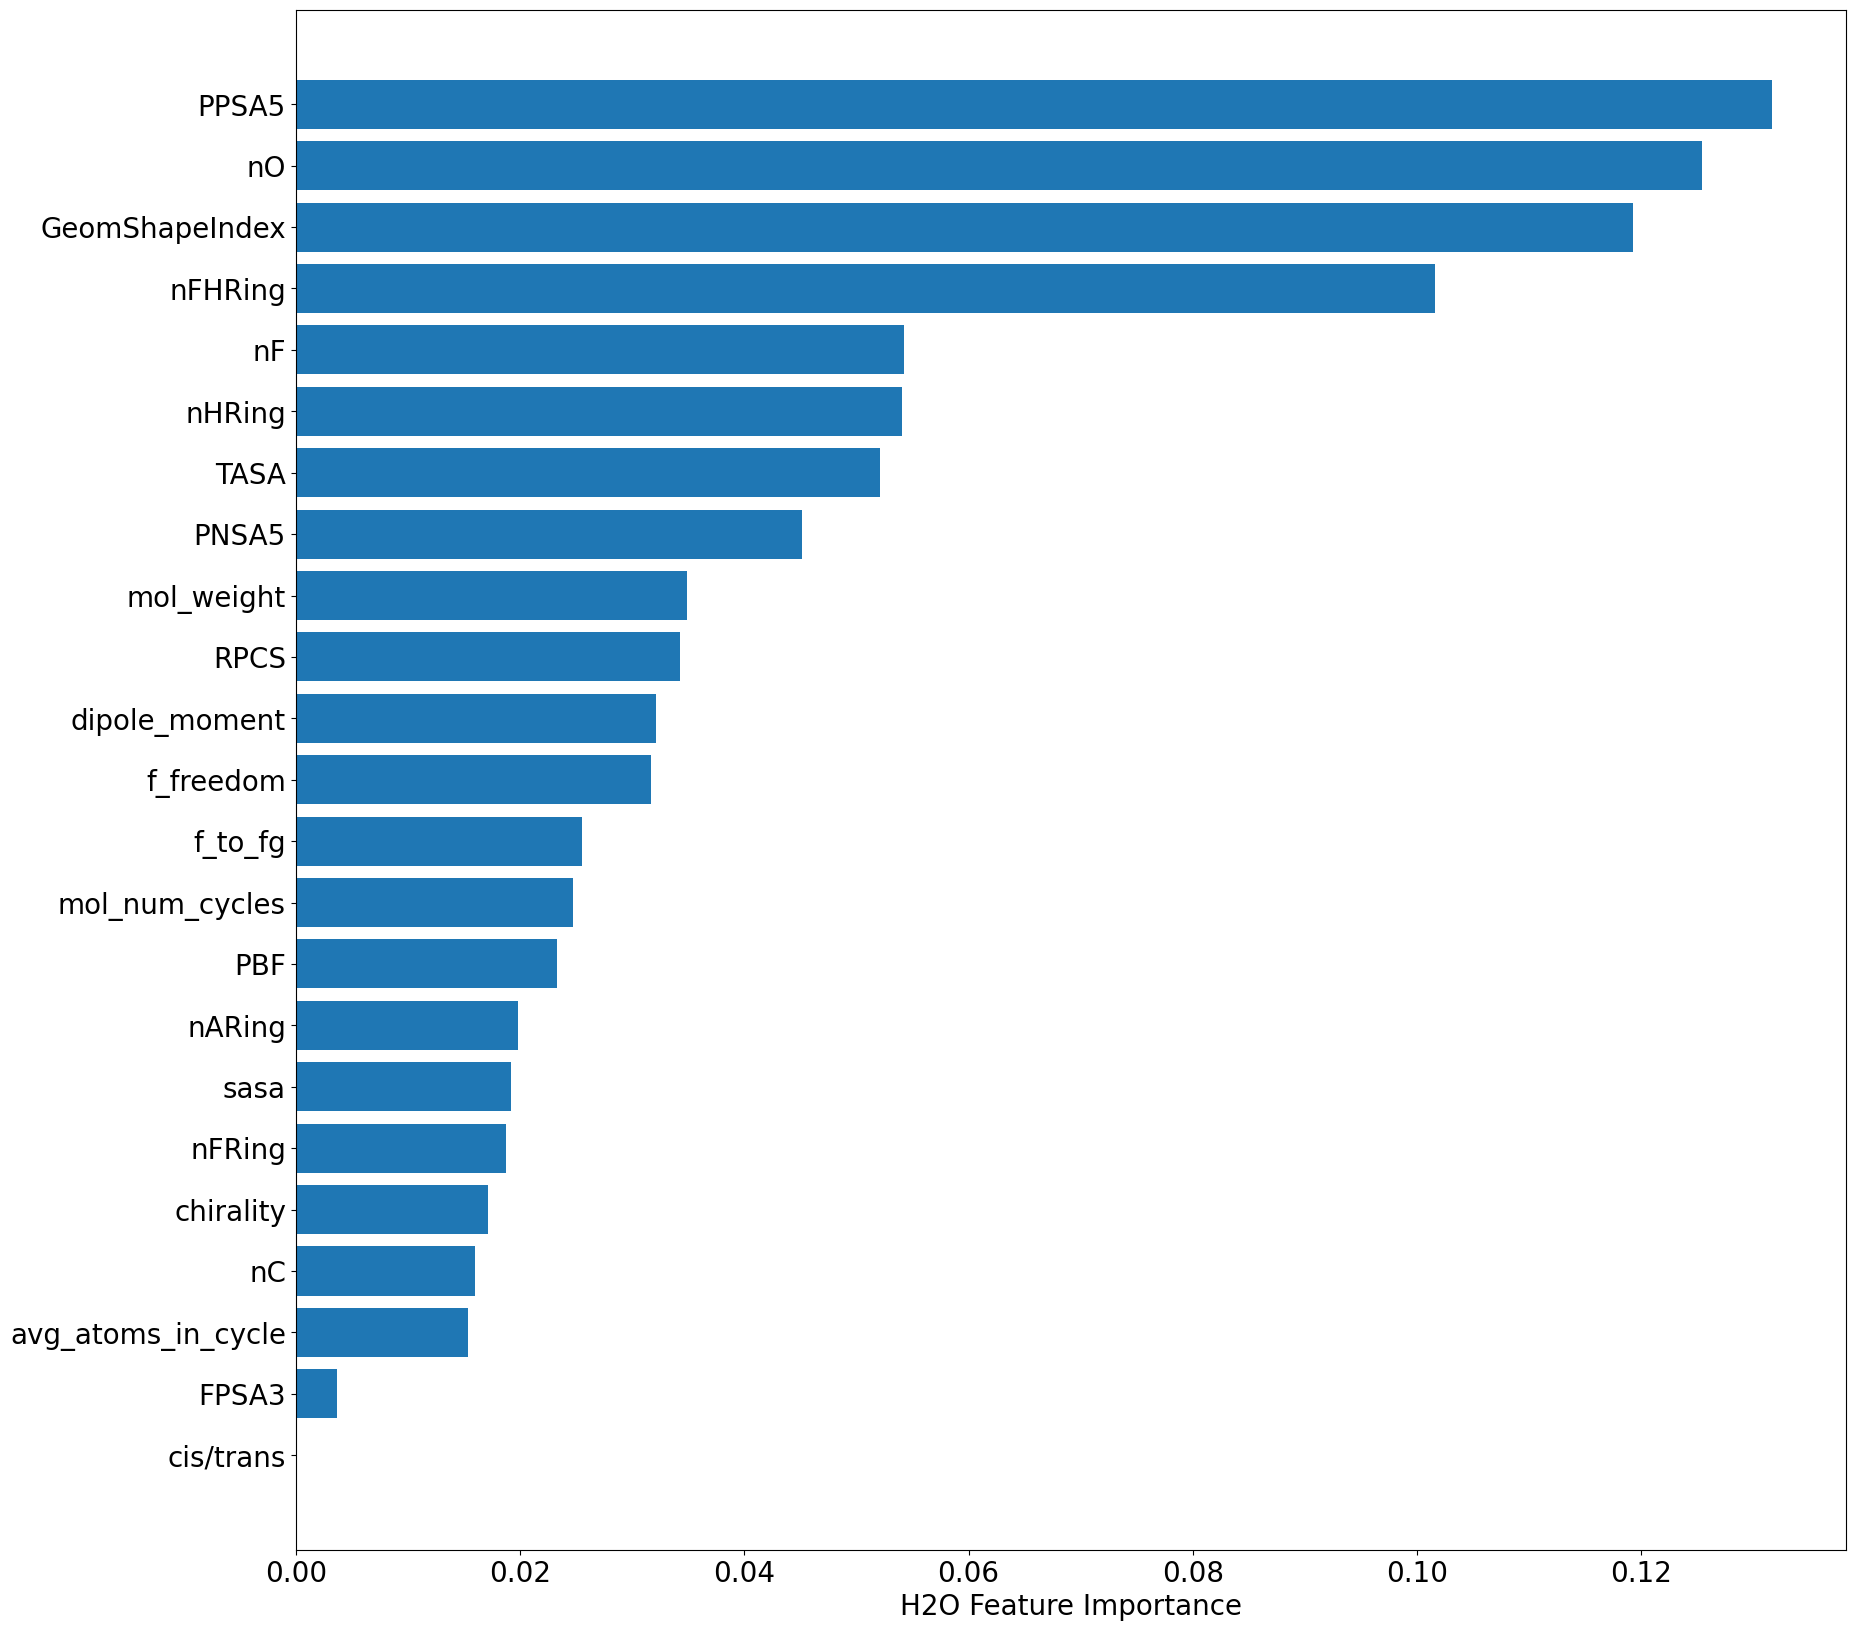

In [37]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\explanation\_explain.py:611: RuntimeWarning: invalid value encountered in divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


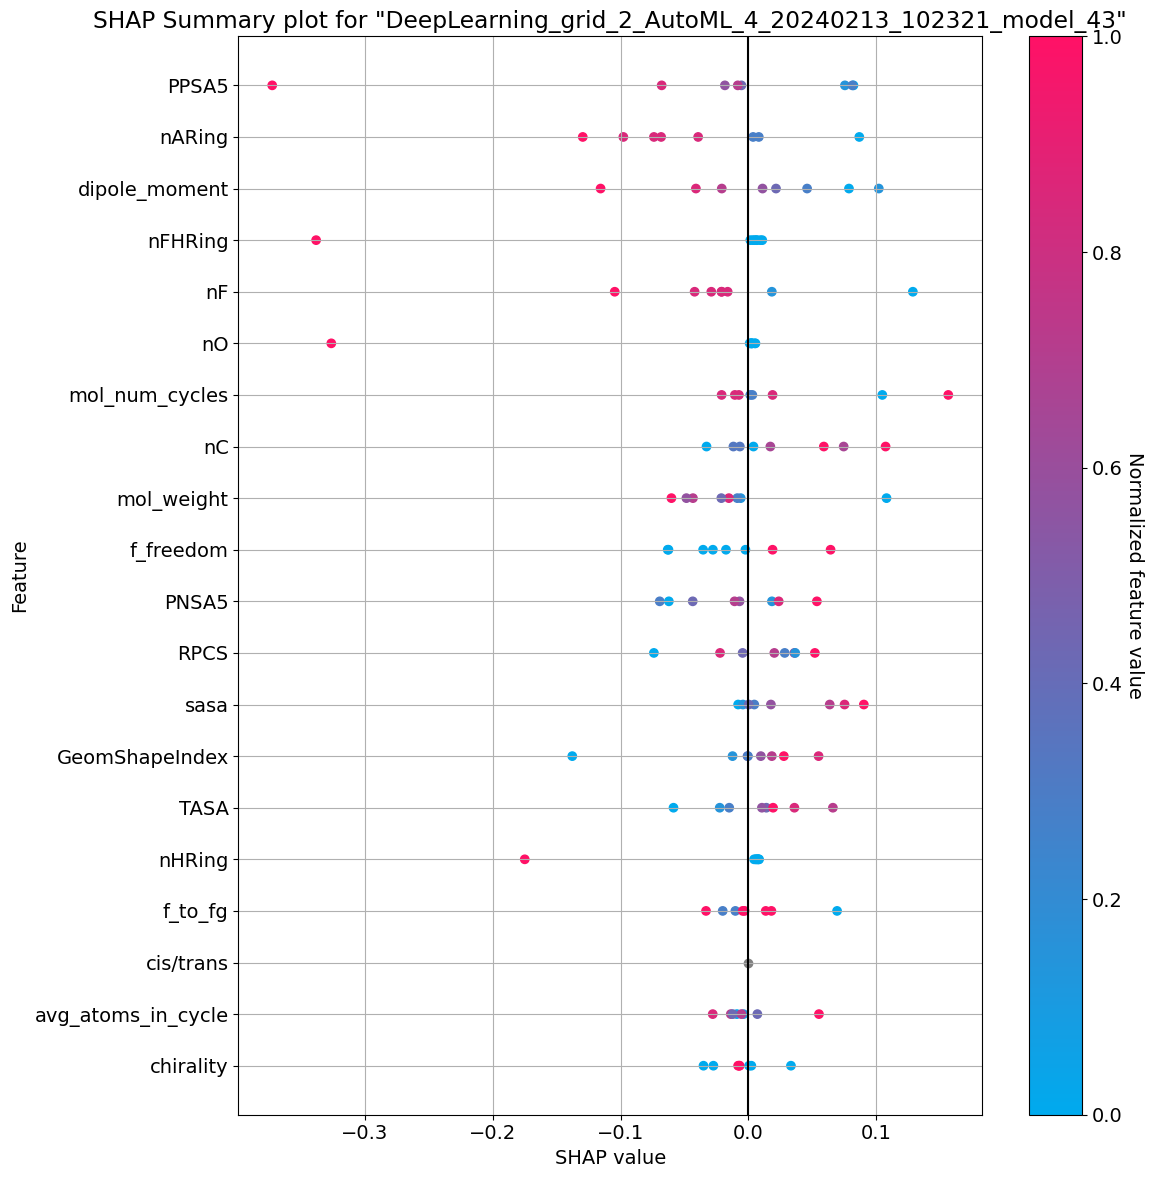

In [38]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=1000)

VAR IMPORTANCE

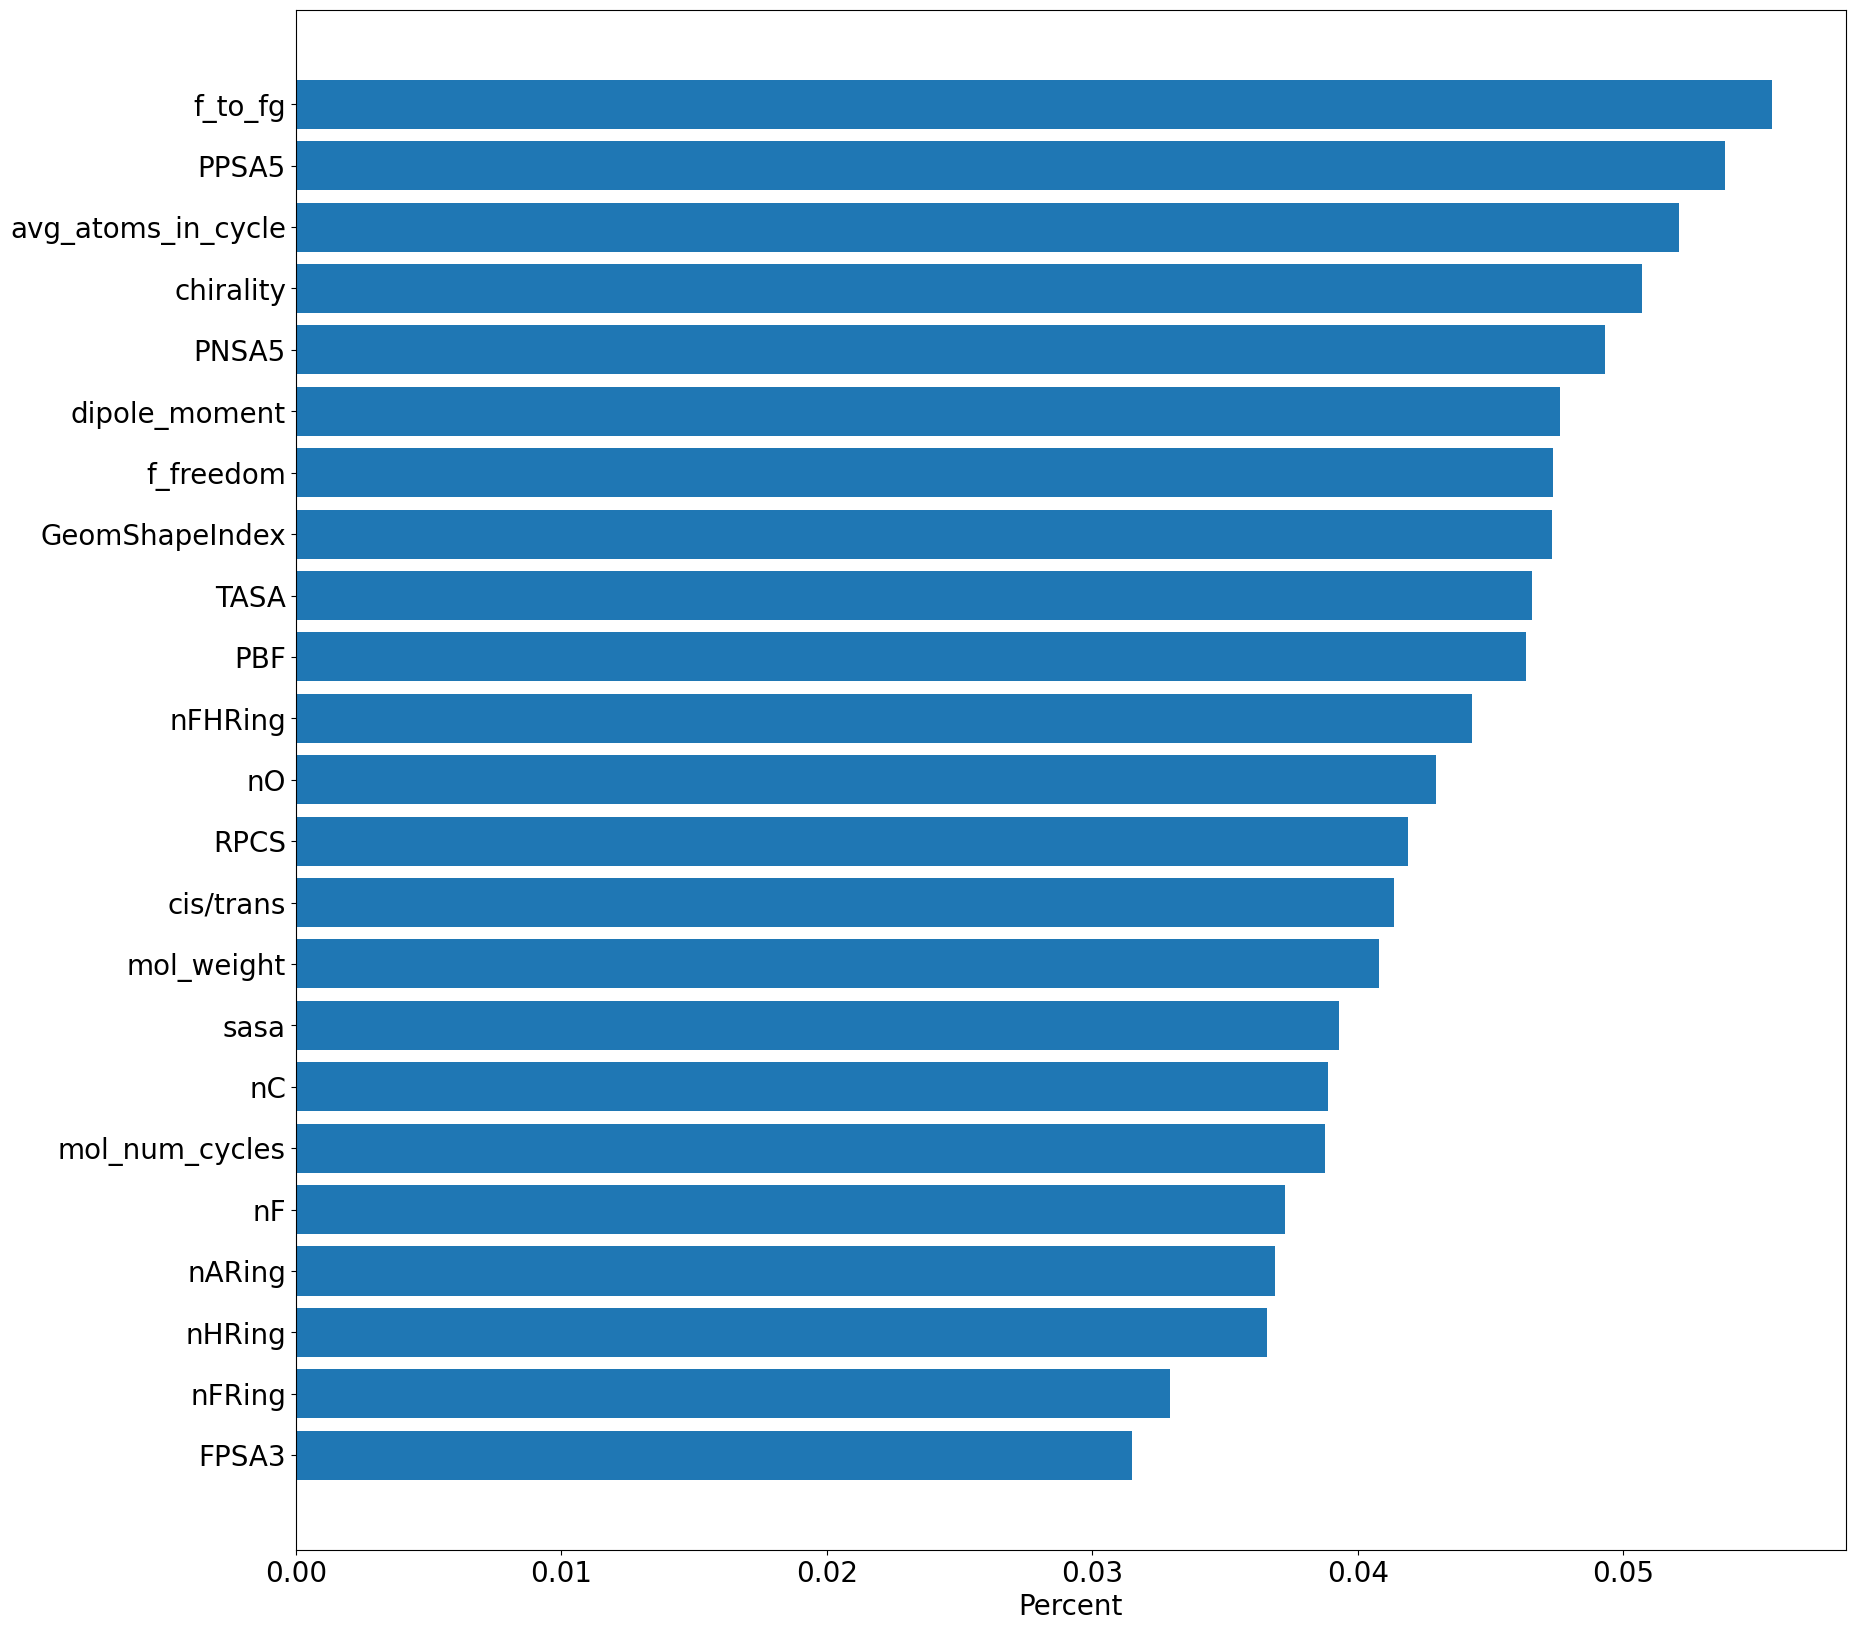

In [39]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

importance = best_model.varimp(test)

if importance is not None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
    ax.set_xlabel('Percent')


In [40]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\08.02.24_feature_2.2\pKa'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'acid_molecules(without_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\pKa\\acid_molecules(without_angle_feature)_without_outliers\\DeepLearning_grid_2_AutoML_4_20240213_102321_model_43'